In [1]:
import numpy as np 
import pandas as pd
import os 
import pickle
from imageio.v2 import imread
import imageio.v2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dense, Flatten, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.image import imread 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import peak_signal_noise_ratio as psnr

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

2024-06-11 11:07:00.205674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 11:07:00.205811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 11:07:00.372619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def numerical_sort(value):
    numeric_part = ''.join(filter(str.isdigit, value))
    if numeric_part:
        return int(numeric_part)
    else:
        return float('inf')

def save_images_in_chunks(low_dir, high_dir, chunk_size=100):
    low_images = []
    high_images = []
    low_files = sorted(os.listdir(low_dir), key=numerical_sort)
    high_files = sorted(os.listdir(high_dir), key=numerical_sort)

    for i, (low_file, high_file) in enumerate(zip(low_files, high_files)):
        if low_file.endswith('.png') and high_file.endswith('.png'):
            low_img_path = os.path.join(low_dir, low_file)
            high_img_path = os.path.join(high_dir, high_file)
            low_images.append(imageio.v2.imread(low_img_path))
            high_images.append(imageio.v2.imread(high_img_path))

        if (i + 1) % chunk_size == 0 or (i + 1) == len(low_files):
            chunk_index = i // chunk_size
            with open(f'low_images_chunk_{chunk_index}.pkl', 'wb') as f:
                pickle.dump(low_images, f)
            with open(f'high_images_chunk_{chunk_index}.pkl', 'wb') as f:
                pickle.dump(high_images, f)
            print(f'Saved chunk {chunk_index}')
            low_images = []
            high_images = []

def load_images_from_chunks(low_chunk_files, high_chunk_files):
    low_images = []
    high_images = []
# pickle.load() is used to load previously serialized (pickled) images from chunk files.
    for low_chunk_file, high_chunk_file in zip(low_chunk_files, high_chunk_files):
        with open(low_chunk_file, 'rb') as f:
            chunk_low_images = pickle.load(f)
            low_images.extend(chunk_low_images)
        with open(high_chunk_file, 'rb') as f:
            chunk_high_images = pickle.load(f)
            high_images.extend(chunk_high_images)

    low_images_normalized = np.array(low_images) / 255.0
    high_images_normalized = np.array(high_images) / 255.0

    return low_images_normalized, high_images_normalized

low_dir = "/kaggle/input/train-dataset-main/low"
high_dir = "/kaggle/input/train-dataset-main/high"
save_images_in_chunks(low_dir, high_dir, chunk_size=100)

low_chunk_files = [f'low_images_chunk_{i}.pkl' for i in range(len(os.listdir(low_dir)) // 100 + 1)]
high_chunk_files = [f'high_images_chunk_{i}.pkl' for i in range(len(os.listdir(high_dir)) // 100 + 1)]

low_images_normalized, high_images_normalized = load_images_from_chunks(low_chunk_files, high_chunk_files)
print(low_images_normalized.shape, high_images_normalized.shape)

Saved chunk 0
Saved chunk 1
Saved chunk 2
Saved chunk 3
Saved chunk 4
(485, 400, 600, 3) (485, 400, 600, 3)


In [3]:
from sklearn.model_selection import train_test_split
def split_in_chunks(arrays, val_size=0.2, test_size=0.1, random_state=None):
    train_arrays = []
    val_arrays = []
    test_arrays = []
    for array in arrays:
        train_array, remaining_array = train_test_split(array, test_size=val_size+test_size, random_state=random_state)
        val_array, test_array = train_test_split(remaining_array, test_size=test_size/(val_size+test_size), random_state=random_state)
        train_arrays.append(train_array)
        val_arrays.append(val_array)
        test_arrays.append(test_array)
    return tuple(train_arrays), tuple(val_arrays), tuple(test_arrays)
arrays = [low_images_normalized, high_images_normalized]
train_arrays, val_arrays, test_arrays = split_in_chunks(arrays, val_size=0.2, test_size=0.1, random_state=42)

train_low_images, train_high_images = train_arrays
val_low_images, val_high_images = val_arrays
test_low_images, test_high_images = test_arrays


print(f"Train low images shape: {train_low_images.shape}")
print(f"Validation low images shape: {val_low_images.shape}")
print(f"Test low images shape: {test_low_images.shape}")
print(f"Train high images shape: {train_high_images.shape}")
print(f"Validation high images shape: {val_high_images.shape}")
print(f"Test high images shape: {test_high_images.shape}")


Train low images shape: (339, 400, 600, 3)
Validation low images shape: (97, 400, 600, 3)
Test low images shape: (49, 400, 600, 3)
Train high images shape: (339, 400, 600, 3)
Validation high images shape: (97, 400, 600, 3)
Test high images shape: (49, 400, 600, 3)


In [5]:

# encoder
encoder_input = Input(shape = train_low_images.shape[1:])
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D(pool_size = (2,2), padding = 'same')(x)

# decoder
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
decoded = Conv2D(3, (3,3), activation = 'sigmoid', padding = 'same')(x)


autoencoder = Model(encoder_input, decoded, name = 'Denoising_Model')
autoencoder.summary()

Model: "Denoising_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 400, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 400, 600, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 400, 600, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 200, 300, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 300, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 200, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 100, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 100, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 200, 300, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 200, 300, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 400, 600, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 400, 600, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,019 (117.26 KB)

 Trainable params: 29,763 (116.26 KB)

 Non-trainable params: 256 (1.00 KB)

In [6]:
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("denoising_model.keras", save_best_only=True, save_weights_only=False, verbose=1)
history = autoencoder.fit(train_low_images, train_high_images, batch_size=2, epochs=10, callbacks=[checkpoint], validation_data=(val_low_images, val_high_images), verbose=2)

In [7]:
from keras.models import load_model
autoencoder = load_model("denoising_model.keras")
autoencoder.summary()

Model: "Denoising_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 400, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 400, 600, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 400, 600, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 200, 300, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 200, 300, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 100, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 200, 300, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 200, 300, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 200, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 400, 600, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 400, 600, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,547 (349.80 KB)

 Trainable params: 29,763 (116.26 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 59,528 (232.54 KB)

In [8]:
train_pred= autoencoder.predict(train_low_images)
val_pred = autoencoder.predict(val_low_images)
test_pred = autoencoder.predict(test_low_images)

11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


In [9]:
def calculate_psnr(original, denoised):
    psnr_values = [psnr(original[i], denoised[i], data_range=original[i].max() - original[i].min()) for i in range(len(original))]
    average_psnr = np.mean(psnr_values)
    print(f"Average PSNR for training dataset is : {average_psnr}")
    return psnr_values
psnr_value_train = calculate_psnr(train_high_images,train_pred)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(train_high_images.flatten(),train_pred.flatten())

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(train_high_images.flatten(),train_pred.flatten())

print("Mean Squared Error on the training dataset is:",mse)
print("Mean absolute Error on the training dataset is:",mae)

Average PSNR for training dataset is : 17.111931260656362
Mean Squared Error on the training dataset is: 0.024261177003964636
Mean absolute Error on the training dataset is: 0.12396351285703382


In [10]:
def calculate_psnr(original, denoised):
    psnr_values = [psnr(original[i], denoised[i], data_range=original[i].max() - original[i].min()) for i in range(len(original))]
    average_psnr = np.mean(psnr_values)
    print(f"Average PSNR for validation dataset is : {average_psnr}")
    return psnr_values
psnr_value_train = calculate_psnr(val_high_images,val_pred)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(val_high_images.flatten(),val_pred.flatten())

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(val_high_images.flatten(),val_pred.flatten())

print("Mean Squared Error on the validation dataset is:",mse)
print("Mean absolute Error on the validation dataset is:",mae)

Average PSNR for validation dataset is : 16.960320444957443
Mean Squared Error on the validation dataset is: 0.025245640522894356
Mean absolute Error on the validation dataset is: 0.12550992257383703


In [11]:
def calculate_psnr(original, denoised):
    psnr_values = [psnr(original[i], denoised[i], data_range=original[i].max() - original[i].min()) for i in range(len(original))]
    average_psnr = np.mean(psnr_values)
    print(f"Average PSNR for test dataset is : {average_psnr}")
    return psnr_values
psnr_value_train = calculate_psnr(test_high_images,test_pred)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_high_images.flatten(),test_pred.flatten())

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_high_images.flatten(),test_pred.flatten())

print("Mean Squared Error on the testing dataset is:",mse)
print("Mean absolute Error on the testing dataset is:",mae)

Average PSNR for test dataset is : 17.04260436423005
Mean Squared Error on the testing dataset is: 0.024090029041307807
Mean absolute Error on the testing dataset is: 0.12551238137841475


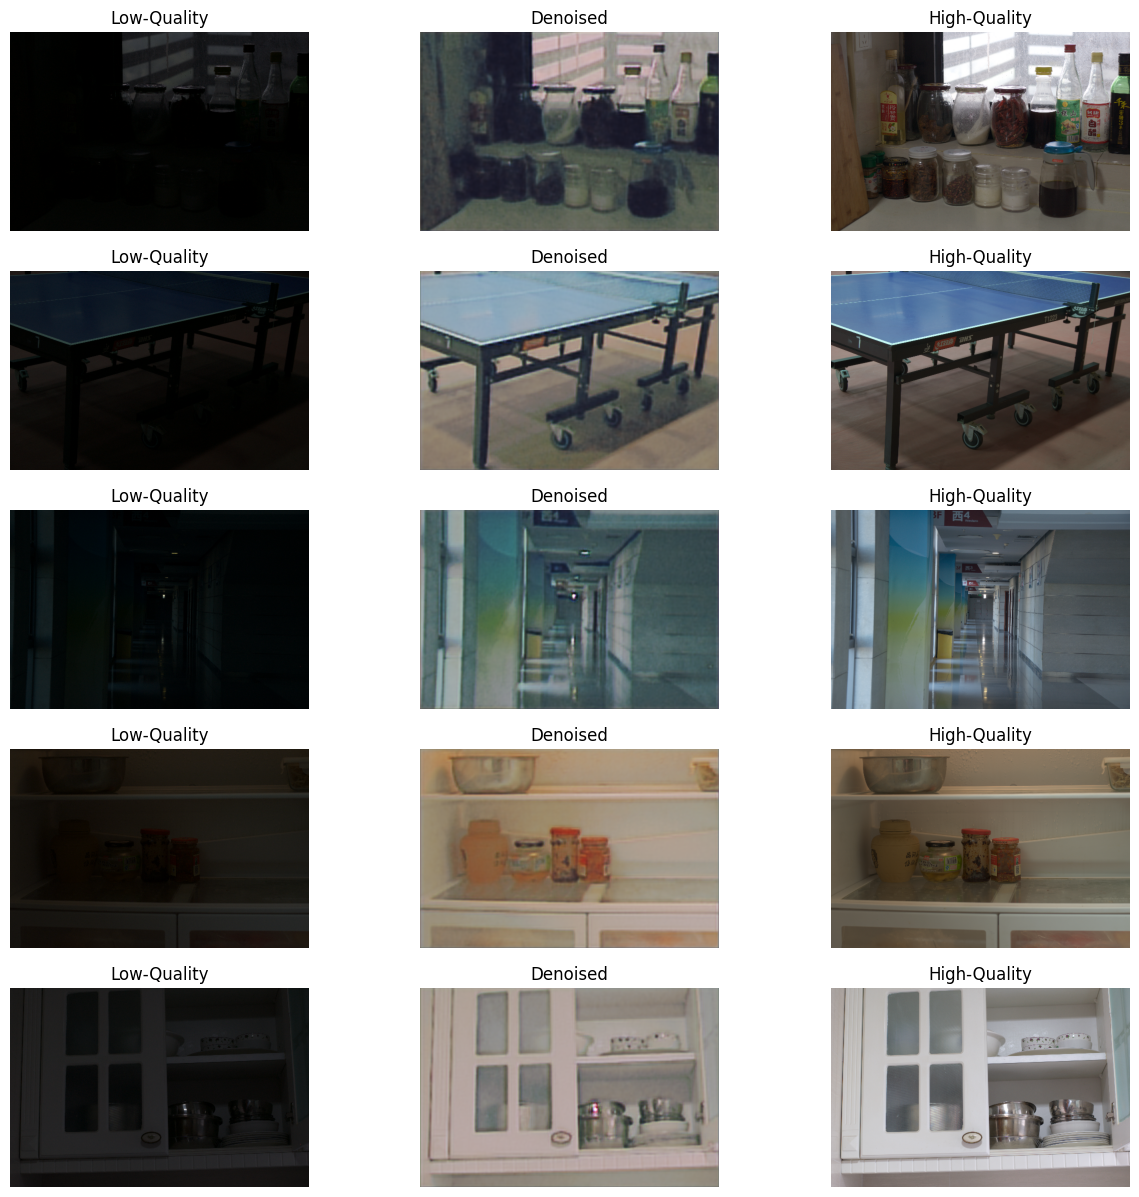

In [12]:
import matplotlib.pyplot as plt

def plot_images(original, denoised, ground_truth, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(test_low_images[i])
        plt.title("Low-Quality")
        plt.axis("off")

        ax = plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(test_pred[i])
        plt.title("Denoised")
        plt.axis("off")
        ax = plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(test_high_images[i])
        plt.title("High-Quality")
        plt.axis("off")
    
    plt.show()
plot_images(test_low_images,test_pred,test_high_images,num_images = 5)

In [ ]:

def load_and_normalize_images(directory):
    images = []
    files = sorted(os.listdir(directory))
    for file in files:
            img_path = os.path.join(directory, file)
            img = imageio.v2.imread(img_path)
            images.append(img)
    # Normalize images
    images_normalized = np.array(images) / 255.0
    return images_normalized

low_dir = "/kaggle/input/test/low"

# Load and normalize images from low_dir
low_images_normalized = load_and_normalize_images(low_dir)
print("Low images shape:", low_images_normalized.shape)

In [ ]:
pred_test1 = autoencoder.predict(low_images_normalized)

In [ ]:
pred_test1[0].shape

In [ ]:
import os
import imageio
output_dir = "/kaggle/input/test/predicted"

# Save each predicted image as an individual file
for i, image_array in enumerate(pred_test1):
    # Scale the pixel values back to the range [0, 255]
    image_scaled = (image_array * 255).astype(np.uint8)
    
    # Define the filename for the image
    filename = os.path.join(output_dir, f"predicted_image_{i}.png")
    
    # Save the image
    imageio.imsave(filename, image_scaled)
